<a href="https://colab.research.google.com/github/alunfes/GoogleColabProjects/blob/main/DQN_Trading_Chase_Limit_Order.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:

#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2024-01-17 13:21:07--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving sourceforge.net (sourceforge.net)... 172.64.150.145, 104.18.37.111, 2606:4700:4400::ac40:9691, ...
Connecting to sourceforge.net (sourceforge.net)|172.64.150.145|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/ [following]
--2024-01-17 13:21:07--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download [following]
--2024-01-17 13:21:08--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, aw

In [11]:
import pandas as pd
import os
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
import datetime
import talib as ta
from collections import deque, namedtuple
from numba import jit, njit

In [12]:
################################################################################
########################## Config ####################################
################################################################################
ohlc_directory = '/content/drive/My Drive/MarketData/ohlc'
model_directory = '/content/drive/My Drive/Model/'

In [13]:
################################################################################
########################## MarketData ####################################
################################################################################
class MarketData:
    @classmethod
    def initialize(cls, terms:list):
        cls.terms = terms
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.dt = []
        cls.ma_kairi = {} #term:ma_kairi
        cls.rsi = {} # 0 - 1.0
        cls.adx = {} #0.0 - 0.6
        cls.cci = {} #-1.0 - 1.0
        cls.cmo = {} #-1.0 - 1.0
        cls.dx = {} #0.0 - 1.0
        cls.minus_di = {} #0.0 - 1.0
        cls.plus_di = {} #0.0 - 1.0
        cls.rocr = {} #0.8 - 1.1
        cls.correl = {} #-1.0 - 1.0
        cls.__read_data()
        cls.__calc_all_index()


    @classmethod
    def __read_data(cls):
        df = pd.read_csv(ohlc_directory+'/bybit-USDT-BTC.csv')
        cls.open = np.array(df['open'].tolist())
        cls.high = np.array(df['high'].tolist())
        cls.low = np.array(df['low'].tolist())
        cls.close = np.array(np.array(df['close'].tolist()))
        cls.dt = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    @classmethod
    def __calc_all_index(cls):
        for term in cls.terms:
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)
            cls.rsi[term] = cls.__calc_rsi(term)
            cls.adx[term] = cls.__calc_adx(term)
            cls.cci[term] = cls.__calc_cci(term)
            cls.cmo[term] = cls.__calc_cmo(term)
            cls.dx[term] = cls.__calc_dx(term)
            cls.minus_di[term] = cls.__calc_minus_di(term)
            cls.plus_di[term] = cls.__calc_plus_di(term)
            cls.rocr[term] = cls.__calc_rocr(term)
            cls.correl[term] = cls.__calc_correl(term)

    @classmethod
    def __calc_ma_kairi(cls, term):
        '''
        ma = pd.Series(cls.close).rolling(window=term).mean()  # 移動平均を計算
        ma_kairi = ((pd.Series(cls.close) - ma) / ma) * 100  # 乖離率を計算
        ma_kairi[:term] = np.nan  # 最初のterm要素をnanに設定
        return ma_kairi.tolist()
        '''
        # Calculate moving average using talib's SMA (Simple Moving Average) function
        ma = ta.SMA(np.array(cls.close, dtype='f8'), timeperiod=term)
        # Calculate the deviation (kairi) from the moving average
        ma_kairi = ((np.array(cls.close, dtype='f8') - ma) / ma) * 100
        return ma_kairi

    @classmethod
    def __calc_rsi(cls, term):
        return ta.RSI(np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_adx(cls, term):
        return ta.ADX(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_cci(cls, term):
        return ta.CCI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 1500

    @classmethod
    def __calc_cmo(cls, term):
        return ta.CMO(np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_dx(cls, term):
        return ta.DX(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_minus_di(cls, term):
        return ta.MINUS_DI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_plus_di(cls, term):
        return ta.PLUS_DI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_rocr(cls, term):
        return ta.ROCR100(np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_correl(cls, term):
        return ta.CORREL(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), timeperiod=term)



    @classmethod
    def generate_state(cls, current_index):
        state = []
        for term in cls.terms:
            # 各指標の値をリストに追加
            term_state = [
                cls.ma_kairi[term][current_index],
                cls.rsi[term][current_index],
                cls.adx[term][current_index],
                cls.cci[term][current_index],
                cls.cmo[term][current_index],
                cls.dx[term][current_index],
                cls.minus_di[term][current_index],
                cls.plus_di[term][current_index],
                cls.rocr[term][current_index],
                cls.correl[term][current_index],
            ]
            state.append(term_state)
        return state


MarketData.initialize([5, 15, 60, 120, 240, 720])

entry reward discount= 0.5
Step 0: Action type: 1, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Order Side: [1], Order Ratio: [0.5], Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
reward= 0.0
state= {'position_side': 0.5, 'position_amount_ratio': 0.0, 'holding_period': 0, 'unrealized_pnl_ratio': 0.5, 'order_sides': [1.0], 'order_types': [0.0], 'order_ratios': [0.5]}
Step 1: Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 1, Position Amount: 4994.75, Total Asset: 9992.51, Free Cash: 5000.25, Order Side: [], Order Ratio: [], Total fee: 9.99, Lot 0.52, Unrealized PnL: -2.50, Total Realized PnL: 0.00
reward= -0.004998498579383337
state= {'position_side': 1.0, 'position_amount_ratio': 0.4996000579093791, 'holding_period': 0.05, 'unrealized_pnl_ratio': 0.49875193546250035, 'order_sides': [], 'order_types': [], 'order_ratios': []}
Step 2: Action

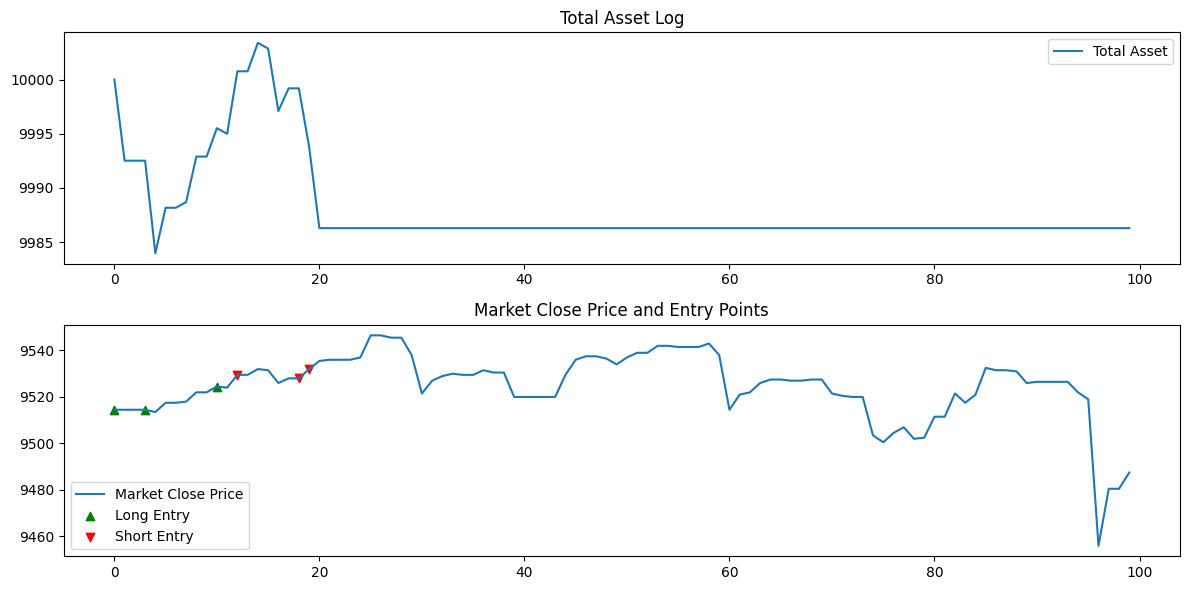

In [17]:
################################################################################
########################## Trading Env ####################################
'''
前提:
Order Cash Ratio: 1.0
・新規エントリ / 追加エントリー: free cashに対する割合
・反対売買:position lotに対する割合
・max_trade_cycle_periodを超えて保有したら強制反対売買させてマイナス報酬。
・order cancel不可（limit order cancel可にすると即時報酬が成り立たなくなる。）
・exitはaction_ind=3のみで可能とする。1, 2を使った反対売買は禁止。（exitの時のaction ratioはentry時と算出式が異なるのでNNに3を使うように学習してほしい）



報酬計算の都度化
報酬計算は都度化出来る、これができればコード・ロジック簡素化、transformer採用が可能になる。
Full Entry: median pnl ratio in the kijun period, 1 if median pnl - fee - spread > 0.01, 0 if 0.01 > median pnl - fee - spread > 0, else -1
Hold: 0.01 if current close - pre close >= 0 else -0.01
Full Exit:expected pnl ratio =  actual exit pnl ratio -  median pnl ratio, expected pnl ratio >= 1
Partial Entry: size * median pnl ratio in the kijun period, size * 1 if size * (median pnl - fee - spread) > 0.01, 0 if 0.01 > size * (median pnl - fee - spread) > 0, else size * -1
Partial Exit: 基本はFull exitの計算にsizeをかけたもの、ただし２番目以降のexitについては対象範囲を最初のentryからにすべきか、
Invalid Action: -0.01
Exceeded max trade cycle: market close and assess as Full exit




Actions:
0: no action
1: Partial chase Limit Long Entry Order
2: Partial chase Limit Short Entry Order
3: Partial chase Limit Exit Order


記録：
・Entry時のindexと価格
・Exit時のindexと価格

報酬計算：
entry: 1 or -1, 基準期間内のif plus(best change ratio - max drowdown - fee - spread)
exit: 1 or -1, 基準期間内のif plus(actual exit point - median change ratio - fee - spread)
hold: 0.1 if favorable price change -0.1 if unfavorable price change
invalid action: -0.1


＊任意期間を過ぎても売却しなかった場合は、基準日に強制売却したとして処理する。


Process:
・position side == 0から1 or -1になる新規エントリーと検知、エントリーindを記録
・exitまでの追加購入、holdの記録をとる
・exitを検知して報酬を計算する。
・報酬とone trade completion flagを返す
'''
################################################################################
class TradingEnvChaseLimitOrder:
    def __init__(self,
                 display_flg,
                 start_ind,
                 end_ind,
                 state_length = 10,
                 is_done_pnl_ratio=-0.2,
                 is_done_trade_ratio=6.9e-04,
                 spread_ratio=0.0005,
                 maker_fee_ratio=0.001,
                 taker_fee_ratio=0.007,
                 effective_digits=4,
                 max_trade_cycle_period = 1440,
                 reward_kijun_pnl_ratio = 0.01,
                 num_max_limit_orders = 5,
                 holding_reward_kijun = 0.01,
                 invalid_action_penalty = -0.01,
                 unrealized_pnl_ratio_state_kijun_max = 0.1
                 ):
        self.display_flg = display_flg
        self.start_ind = start_ind
        self.end_ind = end_ind
        self.state_length = state_length
        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.is_done_trade_ratio = is_done_trade_ratio
        self.initial_asset = 10000
        self.spread_ratio = spread_ratio
        self.maker_fee_ratio = maker_fee_ratio
        self.taker_fee_ratio = taker_fee_ratio
        self.effective_digits = effective_digits
        self.max_trade_cycle_period = max_trade_cycle_period
        self.reward_kijun_pnl_ratio = reward_kijun_pnl_ratio
        self.num_max_limit_orders = num_max_limit_orders
        self.holding_reward_kijun = holding_reward_kijun
        self.invalid_action_penalty = invalid_action_penalty
        self.unrealized_pnl_ratio_state_kijun_max = unrealized_pnl_ratio_state_kijun_max
        self.reset()


    def __init_position(self):
        self.position_side = 0
        self.position_price = 0
        self.position_lot = 0
        self.position_entry_ind = 0

    def __update_position(self, side, price, lot, entry_ind):
        self.position_side = side
        self.position_price = price
        self.position_lot = lot
        self.position_entry_ind = entry_ind

    def __add_position(self, side, price, lot):
        if self.position_side == side:
            new_price = (self.position_price * self.position_lot) + (price * lot) / (self.position_lot + lot)
            self.position_price = new_price
            self.position_lot += lot
        else:
            print('Add position should be same exec side !')

    def __subtract_position(self, side, lot):
        if self.position_side != side:
            self.position_lot -= lot
            if self.position_lot <= 0.00001:
                self.__init_position()
        else:
            print('Sutract position should be oppposite exec side !')


    def __get_position_size(self):
        return self.position_price * self.position_lot


    def __init_order(self):
        self.order_side = []
        self.order_price = []
        self.order_cash_ratio = [] #
        self.order_placed_num_steps = []
        self.order_type = [] #0:market, 1:chase limit, 2:reinforcement exit chase limit order
        self.order_price_close_ratio = 0  # Order price / current price ratio
        self.order_amount_close_ratio = 0  # order amount / current price ratio

    def __remove_order(self, oind):
        del self.order_side[oind]
        del self.order_price[oind]
        del self.order_cash_ratio[oind]
        del self.order_placed_num_steps[oind]
        del self.order_type[oind]

    def __add_limit_order(self, oside, oprice, ocash_ratio, order_type:int):
        if len(self.order_side) < self.num_max_limit_orders:
            self.order_side.append(oside)
            self.order_price.append(oprice)
            self.order_cash_ratio.append(ocash_ratio)
            self.order_placed_num_steps.append(self.num_steps)
            self.order_type.append(order_type)
            return len(self.order_side) - 1 #return index of the added order
        else:
            if self.display_flg:
                print('TradingEnv: new order refused as it exceeds max order num!')
            return -1

    def __init_performance(self):
        self.total_asset = self.initial_asset
        self.total_asset_change_ratio = 0
        self.free_cash = self.initial_asset
        self.total_fee = 0
        self.total_pnl = 0
        self.total_realized_pnl = 0
        self.unrealized_pnl = 0
        self.unrealized_pnl_ratio = 0
        self.position_amount_total_asset_ratio = 0 #position lot * position price + unrealized pnl / total asset
        self.num_trade = 0
        self.num_win = 0
        self.win_rate = 0
        self.average_holding_period = 0
        self.total_asset_when_last_entry = 0

    def __init_log(self):
        self.total_asset_log = [self.initial_asset] * self.state_length
        self.free_cash_log = deque([self.initial_asset] * self.state_length, maxlen=self.state_length)
        self.total_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.total_realized_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.unrealized_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.unrealized_pnl_ratio_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_side_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_price_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_amount_total_asset_ratio_log = deque([0] * self.state_length, maxlen=self.state_length)


    def __init_trade_log(self):
        self.entry_ind_log = []
        self.entry_side_log = []
        self.entry_price_log = []
        self.entry_lot_log = []
        self.exit_ind_log = []
        self.exit_side_log = []
        self.exit_price_log = []
        self.exit_lot_log = []
        self.invalid_action_ind = []

    def __add_entry_log(self, ind, entry_side, entry_price, entry_lot):
        self.entry_ind_log.append(ind)
        self.entry_side_log.append(entry_side)
        self.entry_price_log.append(entry_price)
        self.entry_lot_log.append(entry_lot)

    def __add_exit_log(self, ind, exit_side, exit_price, exit_lot):
        self.exit_ind_log.append(ind)
        self.exit_side_log.append(exit_side)
        self.exit_price_log.append(exit_price)
        self.exit_lot_log.append(exit_lot)

    def __init_action_log(self):
        self.action_type = [] #0: no action, 1:long entry, 2:short entry, 3:exit, 4: invalid action
        self.action_side = []
        self.action_ind = [] #start ind + num steps
        self.action_order_ratio = [] #order ratio

    def __add_action_log(self, action_type, action_side, action_ind, action_lot):
        self.action_type.append(action_type)
        self.action_side.append(action_side)
        self.action_ind.append(action_ind)
        self.action_order_ratio.append(action_lot)


    def reset(self):
        self.num_steps = 0
        self.current_action_ind = -1
        self.reward = 0
        self.is_trade_done = 0 #1:done
        self.last_actual_action = 0 #0:no action, 1: long chase limit entry, 2: short chase limit entry, 3: chase limit exit, 4: invalid action
        self.__init_action_log()
        self.__init_position()
        self.__init_order()
        self.__init_performance()
        self.__init_log()
        self.__init_trade_log()
        return self.__generate_state()


    def __calc_total_asset(self):
        return (self.position_price * self.position_lot) + self.free_cash + self.unrealized_pnl


    def __check_is_done(self):
        if self.is_done_pnl_ratio > (self.total_asset - self.initial_asset) / self.initial_asset:
            if self.display_flg:
                print('Env is done due to asset change ratio criteria!')
                print('total asset=',self.total_asset, ', asset ratio=', (self.total_asset - self.initial_asset) / self.initial_asset)
            return True
        elif self.is_done_trade_ratio > (self.num_trade+1) / (self.num_steps+1):
            if self.display_flg:
                print('Env is done due to num trade per step criteria!')
                print('num trade=', self.num_trade, ', steps=', self.num_steps)
            return True
        else:
            return False


    def __calc_unrealized_pnl(self):
        unrealized_pnl = self.position_side * (MarketData.close[self.start_ind + self.num_steps] - self.position_price) * self.position_lot
        return unrealized_pnl

    def __update_total_asset_when_last_entry(self):
        if self.position_entry_ind == self.start_ind + self.num_steps:
            self.total_asset_when_last_entry = self.total_asset

    def __update_performance(self):
        self.__update_total_asset_when_last_entry()
        self.unrealized_pnl = self.__calc_unrealized_pnl()
        self.unrealized_pnl_ratio = 0 if self.unrealized_pnl == 0 else self.unrealized_pnl / self.total_asset_when_last_entry
        self.win_rate = 0 if self.num_trade == 0 else self.num_win / self.num_trade
        self.total_asset = self.__calc_total_asset()
        self.total_asset_change_ratio = (self.total_asset - self.initial_asset) / self.initial_asset
        self.position_amount_total_asset_ratio = ((self.position_lot * self.position_price) + self.unrealized_pnl) / self.total_asset

    def __update_order_index(self):
        current_market_price = MarketData.close[self.start_ind + self.num_steps]
        self.order_price_close_ratio = np.array(self.order_price) / current_market_price
        self.order_amount_close_ratio = np.array(self.order_lot) * current_market_price / self.total_asset

    def __take_log(self):
        self.total_asset_log.append(self.total_asset)
        self.free_cash_log.append(self.free_cash)
        self.total_pnl_log.append(self.total_pnl)
        self.total_realized_pnl_log.append(self.total_realized_pnl)
        self.unrealized_pnl_log.append(self.unrealized_pnl)
        self.unrealized_pnl_ratio_log.append(self.unrealized_pnl_ratio)
        self.position_side_log.append(self.position_side)
        self.position_price_log.append(self.position_price)
        self.position_amount_total_asset_ratio_log.append(self.position_amount_total_asset_ratio)



    ####################################################################################
    #.           Calc Reward.                                                                                      #
    ####################################################################################
    def __calc_no_action_reward(self):
        return self.__calc_no_action_reward_jit(self.position_side, self.holding_reward_kijun, MarketData.close[self.start_ind + self.num_steps + 1], MarketData.close[self.start_ind + self.num_steps], self.position_price, self.position_lot) * self.__calc_exec_portion(self.position_price, self.position_lot)

    @staticmethod
    @jit(nopython=True)
    def __calc_no_action_reward_jit(position_side, holding_reward_kijun, next_close, current_close, position_price, position_lot):
        if position_side == 0:
            return 0
        else:
            return holding_reward_kijun if position_side * (next_close - current_close) > 0 else -holding_reward_kijun

    '''
    entryから一定期間における中央値との差
    '''
    def __calc_entry_chase_limit_order_action_reward(self, exec_ind, exec_side, order_ratio):
        #簡単のために次のohlcのmid priceを約定値とする
        exec_ind = exec_ind + 1
        exec_price = 0.5 * (MarketData.low[exec_ind] + MarketData.high[exec_ind])
        exec_lot = order_ratio * self.free_cash / exec_price
        #max_trade_cycle_periodをもとにrewardを計算する。
        expected_pnl_ratio = -self.maker_fee_ratio + (exec_side * (np.median(np.array(MarketData.close[exec_ind : exec_ind + self.max_trade_cycle_period])) - exec_price) / exec_price)
        reward_discount = self.__calc_exec_portion(exec_price, exec_lot)
        print("entry reward discount=", reward_discount)
        if expected_pnl_ratio >= self.reward_kijun_pnl_ratio:
            return 1.0 * reward_discount
        elif self.reward_kijun_pnl_ratio > expected_pnl_ratio and expected_pnl_ratio > -self.reward_kijun_pnl_ratio:
            return 0.0
        else:
            return -1.0 * reward_discount


    '''
    entryから一定期間における中央値と実際の約定値との差
    median ratio = median price - entry / entry
    exit ratio = exit price - entry / entry
    exit ratio - median ratio
    '''
    def __calc_exit_chase_limit_order_action_reward(self, exec_ind, exec_side, order_ratio):
        exec_ind = exec_ind + 1
        exec_price = 0.5 * (MarketData.low[exec_ind] + MarketData.high[exec_ind])
        median_ratio = -exec_side * (self.position_price - np.median(np.array(MarketData.close[self.position_entry_ind : self.position_entry_ind + self.max_trade_cycle_period]))) / self.position_price
        actual_ratio = -exec_side * (exec_price - np.median(np.array(MarketData.close[self.position_entry_ind : self.position_entry_ind + self.max_trade_cycle_period]))) / self.position_price
        diff_expected_pnl_ratio = actual_ratio - median_ratio
        reward_discount = self.__calc_exec_portion(exec_price, order_ratio * self.position_lot)
        if diff_expected_pnl_ratio >= self.reward_kijun_pnl_ratio:
            return 1.0 * reward_discount
        elif self.reward_kijun_pnl_ratio > diff_expected_pnl_ratio and diff_expected_pnl_ratio > -self.reward_kijun_pnl_ratio:
            return 0.0
        else:
            return -1.0 * reward_discount


    def __calc_invalid_action_reward(self):
        return self.invalid_action_penalty


    def __calc_exec_portion(self, exec_price, exec_lot):
        return (exec_price * exec_lot) / self.total_asset



    def __calc_reward(self):
        #0:no action, 1: long chase limit entry, 2: short chase limit entry, 3: chase limit exit, 4: invalid action
        if self.action_type[-1] == 0 and self.position_side == 0: #no action
            return 0
        elif self.action_type[-1] == 0 and self.position_side != 0: #hold
            return self.__calc_no_action_reward()
        elif self.action_type[-1] in [1,2]: #long /short entry
            return self.__calc_entry_chase_limit_order_action_reward(self.action_ind[-1], self.action_side[-1], self.action_order_ratio[-1])
        elif self.action_type[-1] == 3: #exit
            return self.__calc_exit_chase_limit_order_action_reward(self.action_ind[-1], self.action_side[-1], self.action_order_ratio[-1])
        elif self.action_type[-1] == 4: #invalid
            return self.__calc_invalid_action_reward()




    ####################################################################################
    #.          Generate State                                                                                    #
    ####################################################################################
    '''
    全て0-1に正規化する
    position side: [0,1,-1]
    position amount / total asset
    holdinfg period till the max period
    unrealized pnl ratio
    order sides
    order types #entry or exit
    order ratios
    '''
    def __generate_state(self):
        position_side = (self.position_side + 1) / 2.0
        position_amount_ratio = (self.position_lot * MarketData.close[self.start_ind + self.num_steps]) / self.total_asset
        holding_period = 0 if self.position_side == 0 else (self.start_ind + self.num_steps - self.position_entry_ind)  / self.max_trade_cycle_period
        unrealized_pnl_ratio = (max(min(self.unrealized_pnl_ratio, self.unrealized_pnl_ratio_state_kijun_max), -self.unrealized_pnl_ratio_state_kijun_max) + self.unrealized_pnl_ratio_state_kijun_max) / (2.0 * self.unrealized_pnl_ratio_state_kijun_max)
        order_sides = (np.array(self.order_side) + 1) / 2.0
        order_types = np.array(self.order_type) - 1.0
        order_ratios = np.array(self.order_cash_ratio)
        #return [position_side, position_amount_ratio, holding_period, unrealized_pnl_ratio] + order_sides.tolist() + order_types.tolist() + order_ratios.tolist()
        return {'position_side':position_side, 'position_amount_ratio':position_amount_ratio, 'holding_period':holding_period, 'unrealized_pnl_ratio':unrealized_pnl_ratio, 'order_sides':order_sides.tolist(), 'order_types':order_types.tolist(), 'order_ratios':order_ratios.tolist()}


    def __state_data_format_conversion(self, data):
        f, i = math.modf(data * self.state_length)
        return [1.0] * int(i) + [f] + [0.0] * int(self.state_length - i)


    ####################################################################################
    #            Step and Process Action                                                                         #
    ####################################################################################
        '''
            0: no action
            1: Partial chase Limit Long Entry Order
            2: Partial chase Limit Short Entry Order
            3: Partial chase Limit Exit Order

            約定した後にtake actionでposition side == 0 で action ind == 3を選択することがありうるがこれがinvalid actionになる
        '''
    def step(self, action_ind, action_ratio):
        self.__check_chase_limit_order_execution()
        self.__check_max_trade_cycle_period_exceeding()
        flg_invalid = self.__check_invalid_action(action_ind)
        if not flg_invalid:
            self.__take_action(action_ind, action_ratio)
        else:
            self.last_actual_action = 4
            self.__add_action_log(4, -1, self.start_ind + self.num_steps, 0)
        self.__update_performance()
        self.reward = self.__calc_reward()
        is_done = self.__check_is_done()
        self.__take_log()
        self.num_steps += 1
        return is_done, self.__generate_state(), self.reward
        #return is_done, None, None


    def __check_max_trade_cycle_period_exceeding(self):
        flg = self.__check_max_trade_cycle_period_exceeding_jit(self.position_side, self.start_ind, self.num_steps, self.position_entry_ind, self.max_trade_cycle_period, np.array(self.order_type))
        if flg:
            #self.__take_action(3, 1.0)
            oside = -self.position_side
            oprice = self.__calc_best_bid_ask(oside, MarketData.close[self.start_ind + self.num_steps])
            self.__add_limit_order(oside, oprice, 1.0, 2)
            print('Exceeded max_trade_cycle_period!')
            return True
        else:
            return False

    @staticmethod
    @jit(nopython=True)
    def __check_max_trade_cycle_period_exceeding_jit(position_side:int, start_ind:int, num_steps:int, entry_ind:int, max_trade_cycle_period:int, order_type:list):
        if not 2 in order_type: #iif no existing reinforcement exit order
            if position_side != 0 and start_ind + num_steps - entry_ind >= max_trade_cycle_period:
                return True
            else:
                return False
        else:
            return False

    def __check_invalid_action(self, action_ind:int):
        return self.__check_invalid_action_jit(action_ind, self.position_side, len(self.order_side), self.num_max_limit_orders, np.array(self.order_type))

    @staticmethod
    @jit(nopython=True)
    def __check_invalid_action_jit(action_ind:int, position_side:int, len_order_side:int, num_max_limit_orders:int, order_type:list):
        #positionないのに3を選択した場合
        if position_side == 0 and action_ind == 3:
            #print('positionないのに3を選択した場合')
            return True
        #exitのために1 or 2を選択したばあい
        elif (position_side == 1 and action_ind ==2) or (position_side == -1 and action_ind == 1):
            #print('#exitのために1 or 2を選択したばあい')
            return True
        #max orderを超えて注文した場合
        elif len_order_side >= num_max_limit_orders and action_ind in [1,2]:
            #print('#max orderを超えて注文した場合')
            return True
        #reinforcement exit order中に新しいorder入れた場合
        elif 2 in order_type and action_ind in [1,2,3]:
            #print('#reinforcement exit order中に新しいorder入れた場合')
            return True
        # order ratio == 1のexit order中に他のorderを入れた場合
        else:
            return False



    def __calc_best_bid_ask(self, oside:int, ref_price:float):
        return self.__calc_best_bid_ask_jit(oside, ref_price, self.spread_ratio)

    @staticmethod
    @jit(nopython=True)
    def __calc_best_bid_ask_jit(oside:int, ref_price:float, spread_ratio:float):
        return ref_price * (1.0 + spread_ratio) if oside == 1 else ref_price * (1.0 - spread_ratio)



    def __take_action(self, action_ind, action_ratio):
        if action_ind == 0:
            self.last_actual_action = 0
            self.__add_action_log(0, 0, self.start_ind+self.num_steps,0)
        elif self.position_side == 0 and action_ind in [1,2]: #new entry
            oside = {1:1, 2:-1}[action_ind]
            oprice = self.__calc_best_bid_ask(oside, MarketData.close[self.start_ind + self.num_steps])
            self.__add_limit_order(oside, oprice, action_ratio, 1)
            self.last_actual_action = action_ind
            self.__add_action_log(action_ind, oside, self.start_ind+self.num_steps, action_ratio)
        elif self.position_side == 1 and action_ind == 1 or self.position_side == -1 and action_ind == 2: #additional entry
            oside = {1:1, 2:-1}[action_ind]
            oprice = self.__calc_best_bid_ask(oside, MarketData.close[self.start_ind + self.num_steps])
            self.__add_limit_order(oside, oprice, action_ratio, 1)
            self.last_actual_action = action_ind
            self.__add_action_log(action_ind, oside, self.start_ind+self.num_steps, action_ratio)
        elif self.position_side != 0 and action_ind == 3: #exit order
            oside = -self.position_side
            oprice = self.__calc_best_bid_ask(oside, MarketData.close[self.start_ind + self.num_steps])
            if (self.position_lot * self.position_price) / self.free_cash <= 0.05:
                action_ratio = 1.0
            self.__add_limit_order(oside, oprice, action_ratio, 1)
            self.last_actual_action = action_ind
            self.__add_action_log(action_ind, oside, self.start_ind+self.num_steps, action_ratio)
        else:
            print('Invalid Action!', ', position side=',self.position_side, ', action ind=',action_ind, 'action ratio=', action_ratio, ', orders=',self.order_type)



    ####################################################################################
    #            Check Execution                                                                                  #
    ####################################################################################
    def __check_chase_limit_order_execution(self):
        ind = self.start_ind + self.num_steps
        for oind in reversed(range(len(self.order_side))):
            if self.num_steps > self.order_placed_num_steps[oind]: #発注したstepより後のohlcデータで約定確認
                if self.order_side[oind] == 1:
                    if self.order_price[oind] > MarketData.open[ind]:
                        self.__process_execution('limit', self.order_side[oind], self.order_price[oind], self.order_cash_ratio[oind])
                        self.__remove_order(oind)
                    elif MarketData.open[ind] == MarketData.low[ind] and MarketData.high[ind] == MarketData.close[ind]: #約定せずに指値更新
                        self.order_price[oind] = MarketData.high[ind] * (1.0 - self.spread_ratio)
                    elif MarketData.close[ind] >= MarketData.open[ind]: #yosen, open - low - high - closeの順番になると想定するのでopenの時のbest bidで約定
                        exec_price = MarketData.open[ind] * (1.0 - self.spread_ratio)
                        self.__process_execution('limit', self.order_side[oind], exec_price, self.order_cash_ratio[oind])
                        self.__remove_order(oind)
                    else: #insen, open - high - low - closeの順番になると想定するのでhighの時のbest bidで約定
                        exec_price = MarketData.high[ind] * (1.0 - self.spread_reatio)
                        self.__process_execution('limit', self.order_side[oind], exec_price, self.order_cash_ratio[oind])
                        self.__remove_order(oind)
                elif self.order_side[oind] == -1:
                    if self.order_price[oind] < MarketData.open[ind]:
                        self.__process_execution('limit', self.order_side[oind], self.order_price[oind], self.order_cash_ratio[oind])
                        self.__remove_order(oind)
                    elif MarketData.open[ind] == MarketData.high[ind] and MarketData.low[ind] == MarketData.close[ind]: #約定せずに指値更新
                        self.order_price[oind] = MarketData.low[ind] * (1.0 + self.spread_ratio)
                    elif MarketData.close[ind] >= MarketData.open[ind]: #yosen, open - low - high - closeの順番になると想定するのでlowの時のbest askで約定
                        exec_price = MarketData.low[ind] * (1.0 + self.spread_reatio)
                        self.__process_execution('limit', self.order_side[oind], exec_price, self.order_cash_ratio[oind])
                        self.__remove_order(oind)
                    else: #insen, open - high - low - closeの順番になると想定するのでopenの時のbest askで約定
                        exec_price = MarketData.open[ind] * (1.0 - self.spread_reatio)
                        self.__process_execution('limit', self.order_side[oind], exec_price, self.order_cash_ratio[oind])
                        self.__remove_order(oind)



    ####################################################################################
    #            Process Execution                                                                                #
    ####################################################################################
    def __process_execution(self, otype, exec_side, exec_price, ocash_ratio):
        if self.position_side == 0 or self.position_side == exec_side: #new or additional execution
            lot = self.__calc_entry_exec_lot(otype, exec_price, ocash_ratio)
            fee = self.__calc_fee(otype, exec_price, lot)
            self.free_cash -= round(fee + lot * exec_price, self.effective_digits)
            if self.position_side == 0:
                self.__update_position(exec_side, exec_price, lot, self.start_ind + self.num_steps)
            else:
                self.__add_position(exec_side, exec_price, lot)
            self.__add_entry_log(self.start_ind + self.num_steps, exec_side, exec_price, lot)
        elif self.position_side != 0 and self.position_side != exec_side: #exit execution
            #calc executed lot
            exec_lot = self.position_lot * ocash_ratio
            #calc fee
            fee = self.__calc_fee(otype, exec_price, exec_lot)
            #add sold amount to free cash
            self.free_cash += exec_lot * exec_price - fee
            #calc realized pnl
            self.total_realized_pnl += self.__calc_realized_pnl(exec_price, exec_lot)
            #update position data
            self.__subtract_position(exec_side, exec_lot)
            if self.position_side == 0:
                self.num_trade += 1
                self.__check_win_lose()
            self.__add_exit_log(self.start_ind + self.num_steps, exec_side, exec_price, exec_lot)
        else:
            print('Invalid Process Executiuon Status !')


    def __calc_realized_pnl(self, exec_price, exec_lot):
        return self.position_side * (exec_price - self.position_price) * exec_lot


    '''
    entry lot = order ratio * free cash / price
    '''
    def __calc_entry_exec_lot(self, otype, exec_price, ocash_ratio):
        tmp_amount = ocash_ratio * self.free_cash
        tmp_lot = tmp_amount / exec_price
        tmp_fee = self.__calc_fee(otype, exec_price, tmp_lot)
        lot = self.__truncate_number( (tmp_amount - tmp_fee) / exec_price, self.effective_digits)
        return lot

    '''
    exit lot = order ratio * position lot
    '''
    def __calc_exit_exec_lot(self, otype, exec_price, ocash_ratio):
        exit_lot = self.position_lot * ocash_ratio


    def __calc_fee(self, otype, exec_price, exec_lot):
        fee = self.maker_fee_ratio * exec_price * exec_lot if otype == 'limit' else self.taker_fee_ratio * exec_price * exec_lot
        self.total_fee += fee
        return fee


    def __check_win_lose(self):
        if self.__calc_total_asset() > self.total_asset_when_last_entry:
            self.num_win += 1


    def __truncate_number(self, number, decimals=0):
        factor = 10 ** decimals
        return int(number * factor) / factor



######################################################################################################







#chase limit orderのtest
max_trade_cycle_period = 20
env = TradingEnvChaseLimitOrder(display_flg=True, start_ind=100000, end_ind=len(MarketData.close)-1, state_length=1000, max_trade_cycle_period = max_trade_cycle_period)
total_steps = 100
order_probability = 0.005
long_entries, short_entries = [], []  # To track entry points for plotting
exit_step = 0
for step in range(total_steps):
    if step == 0:
        action_type = 1
        action_ratio = 0.5
    elif step == 3:
        action_type = 1
        action_ratio = 1.0
    elif step == 10:
        action_type = 1
        action_ratio = 0.5
    elif step == 12:
        action_type = 2
        action_ratio = 0.5
    elif step == 18:
        action_type = 3
        action_ratio = 0.5
    elif step == 19:
        action_type = 3
        action_ratio = 1.0
    else:
        action_type = 0
    is_done, ac_state, reward = env.step(action_type, action_ratio)
    # Record entry points
    if action_type == 1:
        long_entries.append(step)
    elif action_type == 2:
        short_entries.append(step)
    elif action_type == 3:
        if env.position_side == 1:
            short_entries.append(step)
        else:
            long_entries.append(step)
    # Display information per step
    #print(f"Step {step}:Action type: {action_type}, Asset Ratio: {env.total_asset/env.initial_asset:.2f}, Num Trades: {env.num_trade}, Win Rate: {env.win_rate:.2f}, Position: Side {env.position_side}, Position Amount: {env.position_price * env.position_lot:.2f}, Total Asset: {env.total_asset:.2f}, Free Cash: {env.free_cash:.2f}, Total fee: {env.total_fee:.2f}, Lot {env.position_lot:.2f}, Unrealized PnL: {env.unrealized_pnl:.2f}, Total Realized PnL: {env.total_realized_pnl:.2f}")
    print(f"Step {step}: Action type: {action_type},"
      f" Asset Ratio: {env.total_asset/env.initial_asset:.2f},"
      f" Num Trades: {env.num_trade},"
      f" Win Rate: {env.win_rate:.2f},"
      f" Position: Side {env.position_side},"
      f" Position Amount: {env.position_price * env.position_lot:.2f},"
      f" Total Asset: {env.total_asset:.2f},"
      f" Free Cash: {env.free_cash:.2f},"
      f" Order Side: {env.order_side},"
      f" Order Ratio: {env.order_cash_ratio},"
      f" Total fee: {env.total_fee:.2f},"
      f" Lot {env.position_lot:.2f},"
      f" Unrealized PnL: {env.unrealized_pnl:.2f},"
      f" Total Realized PnL: {env.total_realized_pnl:.2f}")
    print('reward=', reward)
    print('state=', ac_state)
    if is_done:
        print("Environment is done!")
        break




# Plotting
plt.figure(figsize=(12, 6))
# Plot total asset log
plt.subplot(2, 1, 1)
plt.plot(env.total_asset_log[env.state_length:], label='Total Asset')
plt.legend()
plt.title('Total Asset Log')
# Plot MarketData.close with long and short entries
valid_close_data = MarketData.close[env.start_ind:env.start_ind + len(env.total_asset_log[env.state_length:])]
plt.subplot(2, 1, 2)
plt.plot(valid_close_data, label='Market Close Price')
# long_entries と short_entries のクローズ価格を取得
long_close_prices = [MarketData.close[env.start_ind + i] for i in long_entries if env.start_ind + i < len(MarketData.close)]
short_close_prices = [MarketData.close[env.start_ind + i] for i in short_entries if env.start_ind + i < len(MarketData.close)]
# エントリポイントをプロット
plt.scatter(long_entries, long_close_prices, color='green', marker='^', label='Long Entry')
plt.scatter(short_entries, short_close_prices, color='red', marker='v', label='Short Entry')
plt.legend()
plt.title('Market Close Price and Entry Points')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import os
import numpy as np
import random

from numba import jit, njit

class TestTradingEnv:
    def __init__(self, test_var:int):
        self.test_var = test_var

    def do_calc(self, k:int):
        self.k = k
        print(self.__do_calc_jit(self.k))

    @staticmethod
    @jit(nopython=True)
    def __do_calc_jit(k:int):
        if k in [1,2]:
            print('kita')
            return k
        else:
            return 0

env = TestTradingEnv(1)
env.do_calc(1)

kita
1


In [ ]:
##########################################################################################
################################# Replay Memory #######################################
##########################################################################################
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
        self. Transition = namedtuple('Transition', (
            'md_state',
            'md_next_state',
            'ac_state',
            'ac_next_state',
            'action',
            'reward',
            'is_done'))

    def push(self, *args):
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def get_len(self):
        return len(self.memory)


In [ ]:
################################################################################
######################## NN for MarketOrder only Strategy #############################
################################################################################
'''
Inputs:
・ma_kairi * terms
・Hist unrealized pnl ratio
・Hist position side

Outputs:
・0:No, 1:Long Market Order, 2:Short Market Order
'''
################################################################################
class DuelingDQN(nn.Module):
    def __init__(self, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        super(DuelingDQN, self).__init__()
        self.md_state_num = md_state_num
        self.ac_state_num = ac_state_num
        self.num_md_out1 = int(md_state_length * 0.5)
        self.num_ac_out1 = int(ac_state_length * 0.5)
        self.num_md_in2 = int(self.num_md_out1 * md_state_num)
        self.num_md_out2 = int(self.num_md_out1 * md_state_num * 0.5)
        self.num_ac_in2 = int(self.num_ac_out1 * ac_state_num)
        self.num_ac_out2 = int(self.num_ac_out1 * ac_state_num * 0.5)
        self.num_pre_final_out = int(0.5 * (self.num_md_out2 + self.num_ac_out2))
        # Layers
        self.md_linears1 = nn.ModuleList([nn.Linear(md_state_length, md_state_length) for _ in range(md_state_num)])
        self.ac_linears1 = nn.ModuleList([nn.Linear(ac_state_length, ac_state_length) for _ in range(ac_state_num)])
        self.md_linears2 = nn.ModuleList([nn.Linear(md_state_length, self.num_md_out1) for _ in range(md_state_num)])
        self.ac_linears2 = nn.ModuleList([nn.Linear(ac_state_length, self.num_ac_out1) for _ in range(ac_state_num)])
        self.md_con_linears3 = nn.Linear(self.num_md_in2, self.num_md_out2)
        self.ac_con_linears3 = nn.Linear(self.num_ac_in2, self.num_ac_out2)
        self.all_con_linears4 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_md_out2 + self.num_ac_out2)
        self.all_con_linears5 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_pre_final_out)
        # Value and Advantage layers
        self.value = nn.Linear(self.num_pre_final_out, 1)
        self.advantage = nn.Linear(self.num_pre_final_out, output_size)
        # Apply He initialization
        for i in range(md_state_num):
            nn.init.kaiming_uniform_(self.md_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears2[i].weight, nonlinearity='relu')
        for i in range(ac_state_num):
            nn.init.kaiming_uniform_(self.ac_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears2[i].weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.md_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.ac_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears4.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears5.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.value.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.advantage.weight, nonlinearity='relu')


    def forward(self, md_state, ac_state):
        md_out_list = []
        for i in range(self.md_state_num):
            md = md_state[:, i, :]
            md_out = F.relu(self.md_linears1[i](md))
            md_out_list.append(md_out)
        md_out = torch.stack(md_out_list, dim=1)
        ac_out_list = []
        for i in range(self.ac_state_num):
            ac = ac_state[:, i, :]
            ac_out = F.relu(self.ac_linears1[i](ac))
            ac_out_list.append(ac_out)
        ac_out = torch.stack(ac_out_list, dim=1)
        # Second layer processing
        md_out_list = []
        for i in range(self.md_state_num):
            md = md_out[:, i, :]
            md_out_new = F.relu(self.md_linears2[i](md))
            md_out_list.append(md_out_new)
        md_out = torch.stack(md_out_list, dim=1)
        ac_out_list = []
        for i in range(self.ac_state_num):
            ac = ac_out[:, i, :]
            ac_out_new = F.relu(self.ac_linears2[i](ac))
            ac_out_list.append(ac_out_new)
        ac_out = torch.stack(ac_out_list, dim=1)
        # Concatenate and further processing
        md_out = torch.flatten(md_out, start_dim=1)
        ac_out = torch.flatten(ac_out, start_dim=1)
        md_out = F.relu(self.md_con_linears3(md_out))
        ac_out = F.relu(self.ac_con_linears3(ac_out))
        all_concat = torch.cat([md_out, ac_out], dim=1)
        all_concat = F.relu(self.all_con_linears4(all_concat))
        all_concat = F.relu(self.all_con_linears5(all_concat))
        # Value and Advantage calculation
        value = self.value(all_concat)
        advantages = self.advantage(all_concat)
        q_values = value + (advantages - advantages.mean())
        return q_values



SyntaxError: invalid syntax (<ipython-input-1-a2dc339ebe61>, line 416)

In [ ]:
def __subtrace_position(self, side, lot):class DuelingDQNLarge(nn.Module):
    def __init__(self, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        super(DuelingDQNLarge, self).__init__()
        #Size: linera layers
        self.md_state_num = md_state_num
        self.ac_state_num = ac_state_num
        self.md_state_length = md_state_length
        self.ac_state_length = ac_state_length
        self.num_md_out0 = int(md_state_length * 3)
        self.num_ac_out0 = int(ac_state_length * 3)
        self.num_md_out1 = int(md_state_length * 2)
        self.num_ac_out1 = int(ac_state_length * 2)
        #Size: concat layers
        self.num_md_con_in = int(self.md_state_length * md_state_num)
        self.num_md_con_out = int(self.md_state_length * md_state_num)
        self.num_ac_con_in = int(self.ac_state_length * ac_state_num)
        self.num_ac_con_out = int(self.ac_state_length * ac_state_num)
        self.num_md_con_out2 = int(self.num_md_con_out * 0.5)
        self.num_ac_con_out2 = int(self.num_ac_con_out * 0.5)
        #Size: md + ac concat layers
        self.num_all_con_out = int(0.5 * (self.num_md_con_out2  + self.num_ac_con_out2))

        # Layers
        self.md_linears0 = nn.ModuleList([nn.Linear(self.md_state_length, self.num_md_out0) for _ in range(md_state_num)])
        self.ac_linears0 = nn.ModuleList([nn.Linear(self.ac_state_length, self.num_ac_out0) for _ in range(ac_state_num)])
        self.md_linears1 = nn.ModuleList([nn.Linear(self.num_md_out0, self.num_md_out0) for _ in range(md_state_num)])
        self.ac_linears1 = nn.ModuleList([nn.Linear(self.num_ac_out0, self.num_ac_out0) for _ in range(ac_state_num)])
        self.md_linears2 = nn.ModuleList([nn.Linear(self.num_md_out0, self.num_md_out0) for _ in range(md_state_num)])
        self.ac_linears2 = nn.ModuleList([nn.Linear(self.num_ac_out0, self.num_ac_out0) for _ in range(ac_state_num)])
        self.md_linears3 = nn.ModuleList([nn.Linear(self.num_md_out0, self.num_md_out1) for _ in range(md_state_num)])
        self.ac_linears3 = nn.ModuleList([nn.Linear(self.num_ac_out0, self.num_ac_out1) for _ in range(ac_state_num)])
        self.md_linears4 = nn.ModuleList([nn.Linear(self.num_md_out1, self.num_md_out1) for _ in range(md_state_num)])
        self.ac_linears4 = nn.ModuleList([nn.Linear(self.num_ac_out1, self.num_ac_out1) for _ in range(ac_state_num)])
        self.md_linears5 = nn.ModuleList([nn.Linear(self.num_md_out1, self.md_state_length) for _ in range(md_state_num)])
        self.ac_linears5 = nn.ModuleList([nn.Linear(self.num_ac_out1, self.ac_state_length) for _ in range(ac_state_num)])
        #concat layers
        self.md_con_linears1 = nn.Linear(self.num_md_con_in, self.num_md_con_out)
        self.ac_con_linears1 = nn.Linear(self.num_ac_con_in, self.num_ac_con_out)
        self.md_con_linears2 = nn.Linear(self.num_md_con_in, self.num_md_con_out)
        self.ac_con_linears2 = nn.Linear(self.num_ac_con_in, self.num_ac_con_out)
        self.md_con_linears3 = nn.Linear(self.num_md_con_in, self.num_md_con_out2)
        self.ac_con_linears3 = nn.Linear(self.num_ac_con_in, self.num_ac_con_out2)
        #final concat layers
        self.all_con_linears1 = nn.Linear(self.num_md_con_out2 + self.num_ac_con_out2, self.num_md_con_out2 + self.num_ac_con_out2)
        self.all_con_linears2 = nn.Linear(self.num_md_con_out2 + self.num_ac_con_out2, self.num_md_con_out2 + self.num_ac_con_out2)
        self.all_con_linears3 = nn.Linear(self.num_md_con_out2 + self.num_ac_con_out2, self.num_all_con_out)
        self.all_con_linears4 = nn.Linear(self.num_all_con_out, self.num_all_con_out)
        # Value and Advantage layers
        self.value = nn.Linear(self.num_all_con_out, 1)
        self.advantage = nn.Linear(self.num_all_con_out, output_size)
        # Apply He initialization
        for i in range(md_state_num):
            nn.init.kaiming_uniform_(self.md_linears0[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears2[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears3[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears4[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears5[i].weight, nonlinearity='relu')
        for i in range(ac_state_num):
            nn.init.kaiming_uniform_(self.ac_linears0[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears2[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears3[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears4[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears5[i].weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.md_con_linears1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.ac_con_linears1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.md_con_linears2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.ac_con_linears2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.md_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.ac_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears4.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.value.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.advantage.weight, nonlinearity='relu')

    def forward(self, md_state, ac_state):
        #md, ac linear layer processing
        md_out_list, ac_out_list = [], []
        for i in range(self.md_state_num):
            md = md_state[:, i, :]
            md = F.relu(self.md_linears0[i](md))
            md = F.relu(self.md_linears1[i](md))
            md = F.relu(self.md_linears2[i](md))
            md = F.relu(self.md_linears3[i](md))
            md = F.relu(self.md_linears4[i](md))
            md = F.relu(self.md_linears5[i](md))
            md_out_list.append(md)
        md_out = torch.cat(md_out_list, dim=1)
        ac_state = ac_state.unsqueeze(-1)
        for i in range(self.ac_state_num):
            ac = ac_state[:, i, :]
            ac = F.relu(self.ac_linears0[i](ac))
            ac = F.relu(self.ac_linears1[i](ac))
            ac = F.relu(self.ac_linears2[i](ac))
            ac = F.relu(self.ac_linears3[i](ac))
            ac = F.relu(self.ac_linears4[i](ac))
            ac = F.relu(self.ac_linears5[i](ac))
            ac_out_list.append(ac)
        ac_out = torch.cat(ac_out_list, dim=1)
        # Concatenate and further processing
        md_out = torch.flatten(md_out, start_dim=1)
        ac_out = torch.flatten(ac_out, start_dim=1)
        md_out = F.relu(self.md_con_linears1(md_out))
        md_out = F.relu(self.md_con_linears2(md_out))
        md_out = F.relu(self.md_con_linears3(md_out))
        ac_out = F.relu(self.ac_con_linears1(ac_out))
        ac_out = F.relu(self.ac_con_linears2(ac_out))
        ac_out = F.relu(self.ac_con_linears3(ac_out))
        all_concat = torch.cat([md_out, ac_out], dim=1)
        all_concat = F.relu(self.all_con_linears1(all_concat))
        all_concat = F.relu(self.all_con_linears2(all_concat))
        all_concat = F.relu(self.all_con_linears3(all_concat))
        all_concat = F.relu(self.all_con_linears4(all_concat))
        # Value and Advantage calculation
        value = self.value(all_concat)
        advantages = self.advantage(all_concat)
        q_values = value + (advantages - advantages.mean())
        return q_values


In [ ]:
class Agent:
    def __init__(self, load_model, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size, learning_rate=1e-03, BUFFER_SIZE=500000, BATCH_SIZE=1024, UPDATE_EVERY=128,
                 GAMMA=0.98, TAU=0.005, sim_start_ind_scope=[10000, 300000], max_sim_length=1000000, is_done_pnl_ratio=-0.2, is_done_trade_ratio = 6.9e-04, max_trade_cycle_period = 1440):
        self.model_path = model_directory+'dqn_trading_model.pth'
        self.md_state_length = md_state_length
        self.md_state_num = md_state_num
        self.ac_state_length = ac_state_length
        self.ac_state_num = ac_state_num
        self.output_size = output_size
        # Rainbow DQNネットワーク（ローカルとターゲット）
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.qnetwork_local = DuelingDQNLarge(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size).to(self.device)
        self.qnetwork_target = DuelingDQNLarge(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)
        if load_model:
            if os.path.isfile(self.model_path):
                self.__load_model()
                print("Loaded model weights from:", self.model_path)
        self.UPDATE_EVERY = UPDATE_EVERY
        self.GAMMA = GAMMA
        self.TAU = TAU
        # Prioritized Experience Replayメモリ（容量100000）
        self.BATCH_SIZE = BATCH_SIZE
        self.sim_start_ind_scope = sim_start_ind_scope
        self.max_sim_length = max_sim_length
        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.is_done_trade_ratio = is_done_trade_ratio
        self.max_trade_cycle_period = max_trade_cycle_period
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.num_get_reward = 0
        self.num_learned = 0


    def __load_model(self):
        checkpoint = torch.load(self.model_path, map_location=self.device)
        self.qnetwork_local.load_state_dict(checkpoint['model_state_dict'])
        self.qnetwork_target.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.qnetwork_local.train()
        self.qnetwork_target.train()
        self.qnetwork_local = self.qnetwork_local.to(self.device)
        self.qnetwork_target = self.qnetwork_target.to(self.device)
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.device)


    def __save_model(self, model, optimizer):
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, self.model_path)


    def add_memory(self, md_state, md_next_state, ac_state, ac_next_state, action, reward, is_done):
        for i in range(len(md_state)):
            self.memory.push(md_state[i], md_next_state[i], ac_state[i], ac_next_state[i], action[i], reward[i], is_done[i])


    def act(self, md_state, ac_state, eps=0.):
        # Epsilon-greedyによる行動選択
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(md_state, ac_state)
        self.qnetwork_local.train()
        # Epsilon-greedyポリシー
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.output_size))

    def learn(self):
        # 学習間隔ごとに学習
        if (self.num_get_reward + 1) % self.UPDATE_EVERY == 0:
            # メモリからランダムな経験と学習
            if self.memory.get_len() > self.BATCH_SIZE:
                experiences = self.memory.sample(self.BATCH_SIZE)
                batch = self.memory.Transition(*zip(*experiences))
                md_next_state = torch.tensor(batch.md_next_state, dtype=torch.float32).to(self.device)
                md_state = torch.tensor(batch.md_state, dtype=torch.float32).to(self.device)
                ac_next_state = torch.tensor(batch.ac_next_state, dtype=torch.float32).to(self.device)
                ac_state = torch.tensor(batch.ac_state, dtype=torch.float32).to(self.device)
                is_done = torch.tensor(batch.is_done, dtype=torch.float32).unsqueeze(1).to(self.device)
                reward = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(self.device)
                action = torch.tensor(batch.action, dtype=torch.float32).to(self.device)
                Q_targets_next = self.qnetwork_target(md_next_state, ac_next_state).detach().max(1)[0].unsqueeze(1)
                Q_targets = reward + (self.GAMMA * Q_targets_next * (1 - is_done))
                # 予想されるQ値を取得
                action = action.long().unsqueeze(1)  # action を int64 型に変換し、次元を追加
                Q_expected = self.qnetwork_local(md_state, ac_state).gather(1, action)
                # 損失を計算し、バックプロパゲーション
                loss = F.mse_loss(Q_expected, Q_targets)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                # ターゲットネットワークを更新
                self.soft_update(self.qnetwork_local, self.qnetwork_target, self.TAU)
                self.num_learned += 1


    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def train(self, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        scores = []                        # 各エピソードのスコアを保存するリスト
        scores_window = deque(maxlen=100)  # 最後の100スコア
        time_log = deque(maxlen=100)
        num_trade_log = deque(maxlen=100)
        win_rate_log = deque(maxlen=100)
        asset_change_ratio_log = deque(maxlen=100)
        num_steps_log = deque(maxlen=100)
        eps = eps_start                    # Epsilonの初期値
        for i_episode in range(1, n_episodes+1):
            start_time = time.time()  # エピソードの開始時刻
            random_sim_start = random.randint(self.sim_start_ind_scope[0], self.sim_start_ind_scope[1])
            env = TradingEnvOneTradeRewarding(False, start_ind=random_sim_start, end_ind=random_sim_start + self.max_sim_length, state_length=self.ac_state_length, is_done_pnl_ratio=self.is_done_pnl_ratio,
                       is_done_trade_ratio=self.is_done_trade_ratio, max_trade_cycle_period = self.max_trade_cycle_period)
            ac_state = env.reset()            # 環境をリセットして初期状態を取得
            score = 0
            is_done_log = []
            md_state_log = []
            md_next_state_log = []
            ac_state_log = []
            ac_next_state_log = []
            action_log = []
            for t in range(self.max_sim_length):
                md_state = MarketData.generate_state(random_sim_start + t)
                md_next_state = MarketData.generate_state(random_sim_start + t+1)
                action = self.act(torch.tensor(md_state, dtype=torch.float32).unsqueeze(0).to(self.device), torch.tensor(ac_state, dtype=torch.float32).unsqueeze(0).to(self.device), eps)
                is_done, ac_next_state, reward,  = env.step(action, 1.0)
                is_done_log.append(is_done)
                md_state_log.append(md_state)
                md_next_state_log.append(md_next_state)
                ac_state_log.append(ac_state)
                ac_next_state_log.append(ac_next_state)
                action_log.append(action)
                if len(reward) > 0:
                    self.num_get_reward += 1
                    self.add_memory(md_state_log, md_next_state_log, ac_state_log, ac_next_state_log, action_log, reward, is_done_log)
                    self.learn()
                ac_state = ac_next_state
                score += sum(reward)
                if is_done:
                    break
            scores_window.append(score)       # 最新のスコアを保存
            scores.append(score)              # スコアをリストに追加
            time_log.append(time.time() - start_time)
            num_trade_log.append(env.num_trade)
            win_rate_log.append(env.win_rate)
            asset_change_ratio_log.append(env.total_asset_change_ratio)
            num_steps_log.append(env.num_steps)
            eps = max(eps_end, eps_decay*eps) # Epsilonを減衰させる
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                self.__save_model(self.qnetwork_local, self.optimizer)
            if i_episode % 100 == 0:
                print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tNum Learned: {self.num_learned}\tLen Memory: {self.memory.get_len()}\tNum Steps: {np.mean(num_steps_log)}\tNum Trade: {np.mean(num_trade_log)}\tWin Rate: {np.mean(win_rate_log)}\tAsset Change Ratio: {np.mean(asset_change_ratio_log):.2f}\tDuration: {sum(time_log):.2f} sec')
        return scores



# 学習パラメータの設定
load_model = True
ac_state_length = 1
ac_state_num = 3
max_trade_cycle_period = 770
num_md_index = 10
md_state_length = num_md_index
max_sim_length = 1000000
is_done_pnl_ratio = -0.2
is_done_trade_ratio = 6.9e-05
n_episodes = 20000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
UPDATE_EVERY = 128

agent = Agent(load_model, md_state_length, md_state_num=len(MarketData.terms), ac_state_length=ac_state_length, ac_state_num=ac_state_num, output_size=3, learning_rate=1e-03, BUFFER_SIZE=200000, BATCH_SIZE=4096, UPDATE_EVERY=UPDATE_EVERY,
                 GAMMA=0.98, TAU=0.005, sim_start_ind_scope=[10000, 300000], max_sim_length=max_sim_length, is_done_pnl_ratio=is_done_pnl_ratio, is_done_trade_ratio = is_done_trade_ratio,
              max_trade_cycle_period = max_trade_cycle_period)

# 学習の実行
scores = agent.train(n_episodes, eps_start, eps_end, eps_decay)

# 学習の進捗をグラフで表示
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Loaded model weights from: /content/drive/My Drive/Model/dqn_trading_model.pth
Episode 100	Average Score: -16.74	Num Learned: 11	Len Memory: 66324	Num Steps: 84.32	Num Trade: 14.98	Win Rate: 0.0020192307692307693	Asset Change Ratio: -0.20	Duration: 40.46 sec
Episode 200	Average Score: -16.31	Num Learned: 23	Len Memory: 179710	Num Steps: 141.74	Num Trade: 14.97	Win Rate: 0.005922619047619046	Asset Change Ratio: -0.20	Duration: 67.63 sec
Episode 300	Average Score: -15.94	Num Learned: 35	Len Memory: 200000	Num Steps: 232.26	Num Trade: 14.92	Win Rate: 0.011518674136321193	Asset Change Ratio: -0.20	Duration: 104.40 sec
Episode 400	Average Score: -15.62	Num Learned: 46	Len Memory: 200000	Num Steps: 383.8	Num Trade: 14.89	Win Rate: 0.016083800186741364	Asset Change Ratio: -0.20	Duration: 173.17 sec
Episode 500	Average Score: -15.43	Num Learned: 58	Len Memory: 200000	Num Steps: 621.35	Num Trade: 15.01	Win Rate: 0.022048313184923094	Asset Change Ratio: -0.20	Duration: 281.40 sec
Episode 600	Ave

ストリーミング出力は最後の 5000 行に切り捨てられました。
Step 5000: Action type: 0, Asset Ratio: 0.95, Num Trades: 4, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 9453.23, Free Cash: 9453.23, Total fee: 820.55, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: -266.13
Step 5001: Action type: 0, Asset Ratio: 0.95, Num Trades: 4, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 9453.23, Free Cash: 9453.23, Total fee: 820.55, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: -266.13
Step 5002: Action type: 0, Asset Ratio: 0.95, Num Trades: 4, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 9453.23, Free Cash: 9453.23, Total fee: 820.55, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: -266.13
Step 5003: Action type: 0, Asset Ratio: 0.95, Num Trades: 4, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 9453.23, Free Cash: 9453.23, Total fee: 820.55, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: -266.13
Step 5004: A

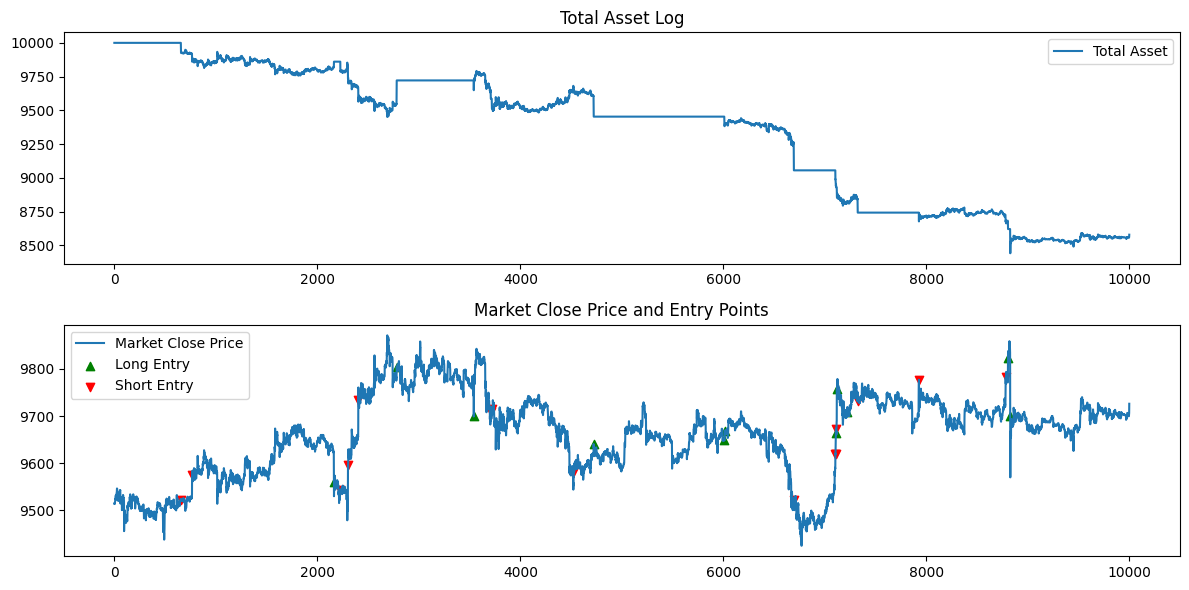

In [ ]:
class LoadModelTradingSimulation:
    def __init__(self, start_index, simulation_length, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        self.model_path = model_directory+'dqn_trading_model.pth'
        self.md_state_length =md_state_length
        self.md_state_num = md_state_num
        self.ac_state_num = ac_state_num
        self.ac_state_length = ac_state_length
        self.output_size = output_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DuelingDQNLarge(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size).to(self.device)
        self.__load_model()
        self.start_index = start_index
        self.simulation_length = simulation_length
        self.current_index = start_index
        self.env = TradingEnvOneTradeRewarding(False, start_ind=self.start_index, end_ind=self.simulation_length + self.start_index, state_length=self.ac_state_length, is_done_pnl_ratio=-0.3,
                       is_done_trade_ratio=0, max_trade_cycle_period = len(MarketData.close))


    def __load_model(self):
        checkpoint = torch.load(self.model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        self.model = self.model.to(self.device)

    def __act(self, md_state, ac_state):
        self.model.eval()
        with torch.no_grad():
            action_values = self.model(md_state, ac_state)
            return np.argmax(action_values.cpu().data.numpy())

    def run_simulation(self):
        ac_state = self.env.reset()  # 環境をリセット
        long_entries, short_entries = [], []  # To track entry points for plotting
        for step in range(self.simulation_length):
            md_state = MarketData.generate_state(self.current_index)
            md_state = torch.tensor(md_state, dtype=torch.float32).unsqueeze(0).to(self.device)
            ac_state = torch.tensor(ac_state, dtype=torch.float32).unsqueeze(0).to(self.device)
            action = self.__act(md_state, ac_state)
            if action == 1:
                long_entries.append(step)
            elif action == 2:
                short_entries.append(step)
            is_done, ac_next_state, reward, = self.env.step(action, 1.0)
            #print(f"Step {step}:Action type: {action}, Asset Ratio: {self.env.total_asset/self.env.initial_asset:.2f}, Num Trades: {self.env.num_trade}, Win Rate: {self.env.win_rate:.2f}, Position: Side {self.env.position_side}, Position Amount: {self.env.position_price * env.position_lot:.2f}, Total Asset: {self.env.total_asset:.2f}, Free Cash: {self.env.free_cash:.2f}, Total fee: {self.env.total_fee:.2f}, Lot {self.env.position_lot:.2f}, Unrealized PnL: {self.env.unrealized_pnl:.2f}, Total Realized PnL: {self.env.total_realized_pnl:.2f}")
            print(f"Step {step}: Action type: {action}, "
                f"Asset Ratio: {self.env.total_asset/self.env.initial_asset:.2f}, "
                f"Num Trades: {self.env.num_trade}, "
                f"Win Rate: {self.env.win_rate:.2f}, "
                f"Position: Side {self.env.position_side}, "
                f"Position Amount: {self.env.position_price * self.env.position_lot:.2f}, "
                f"Total Asset: {self.env.total_asset:.2f}, "
                f"Free Cash: {self.env.free_cash:.2f}, "
                f"Total fee: {self.env.total_fee:.2f}, "
                f"Lot {self.env.position_lot:.2f}, "
                f"Unrealized PnL: {self.env.unrealized_pnl:.2f}, "
                f"Total Realized PnL: {self.env.total_realized_pnl:.2f}")

            ac_state = ac_next_state
            self.current_index += 1
            if is_done:
                print('Is done criteria is reached!')
        self.display_step_info(long_entries, short_entries)


    def display_step_info(self, long_entries, short_entries):
        # Plotting
        plt.figure(figsize=(12, 6))
        # Plot total asset log
        plt.subplot(2, 1, 1)
        plt.plot(self.env.total_asset_log[self.env.state_length:], label='Total Asset')
        plt.legend()
        plt.title('Total Asset Log')
        # Plot MarketData.close with long and short entries
        valid_close_data = MarketData.close[self.env.start_ind:self.env.start_ind + len(self.env.total_asset_log[self.env.state_length:])]
        plt.subplot(2, 1, 2)
        plt.plot(valid_close_data, label='Market Close Price')
        # long_entries と short_entries のクローズ価格を取得
        long_close_prices = [MarketData.close[self.env.start_ind + i] for i in long_entries if self.env.start_ind + i < len(MarketData.close)]
        short_close_prices = [MarketData.close[self.env.start_ind + i] for i in short_entries if self.env.start_ind + i < len(MarketData.close)]
        # エントリポイントをプロット
        plt.scatter(long_entries, long_close_prices, color='green', marker='^', label='Long Entry')
        plt.scatter(short_entries, short_close_prices, color='red', marker='v', label='Short Entry')
        plt.legend()
        plt.title('Market Close Price and Entry Points')
        plt.tight_layout()
        plt.show()


# シミュレーションの設定
start_index = 100000  # 任意の開始位置
simulation_length = 10000  # シミュレーションの長さ
ac_state_num = 3
ac_state_length = 1
max_trade_cycle_period = 770
num_md_index = 10
md_state_length = num_md_index
md_state_num=len(MarketData.terms)
output_size = 3

# シミュレーションの実行
simulation = LoadModelTradingSimulation(start_index, simulation_length, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size)
simulation.run_simulation()


In [ ]:
def test():
    a = np.array([1,2,3])
    c = np.array([1,2,3])
    b = [4,5,6]
    return b + a.tolist() + c.tolist()
test()

[4, 5, 6, 1, 2, 3, 1, 2, 3]

In [ ]:
entry_ind = 10000
current = 10110
maxp = 200
(current - entry_ind) /  maxp

0.55